In [42]:
from datetime import datetime, timedelta
# Unzipping the provided file to check its contents
import zipfile
import os

zip_path = r"C:\Users\xyz\Downloads\ETHUSDT-1h-2023-05.zip"
extract_path = r"C:\Users\xyz\Desktop\bodi2"

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Checking the contents of the extracted folder
extracted_files = os.listdir(extract_path)
extracted_files
# Importing necessary libraries
import pandas as pd

# Loading the CSV file
csv_file_path = os.path.join(extract_path, extracted_files[0])
ohlcv_data = pd.read_csv(csv_file_path)

# Displaying the first few rows of the data
ohlcv_data.head()


,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore
0,1682899200000,1868.41,1885.56,1867.20,1884.08,172201.437,1682902799999,3.233506e+08,151242,91880.163,1.725116e+08,0
1,1682902800000,1884.09,1884.90,1821.17,1834.90,515365.298,1682906399999,9.502794e+08,328909,236639.671,4.360779e+08,0
2,1682906400000,1834.89,1846.19,1832.21,1843.28,204270.793,1682909999999,3.762016e+08,174011,101511.948,1.869391e+08,0
3,1682910000000,1843.28,1846.74,1841.20,1845.94,98998.300,1682913599999,1.825534e+08,96797,50942.213,9.394823e+07,0
4,1682913600000,1845.94,1846.95,1841.44,1846.80,73249.415,1682917199999,1.350939e+08,76832,34362.689,6.338054e+07,0


In [93]:
# Modifying the find_optimized_points function to search only over local extrema
import time
def find_local_extrema(points):
    extrema = []
    for i in range(1, len(points) - 1):
        if (points[i - 1][1] < points[i][1] > points[i + 1][1]) or (points[i - 1][1] > points[i][1] < points[i + 1][1]):
            extrema.append(points[i])
    return extrema

def find_optimized_points_extrema(datum: datetime, time_delta: timedelta, ohlcv_data: pd.DataFrame, coarsening_steps: int = 1):
    end_time = datum.timestamp() * 1000
    start_time = (datum - time_delta).timestamp() * 1000
    selected_data = ohlcv_data[(ohlcv_data['open_time'] >= start_time) & (ohlcv_data['open_time'] <= end_time)]
    selected_points = selected_data[['open_time_normalized', 'close_normalized']].values
    extrema_points = selected_points
    for _ in range(coarsening_steps):
        extrema_points = find_local_extrema(extrema_points)
    all_combinations = combinations(extrema_points, 4)
    max_total_distance = 0
    best_combination = None
    for combination in all_combinations:
        sorted_combination = sorted(combination, key=lambda x: x[0])
        distance_combination = total_distance(sorted_combination)
        if distance_combination > max_total_distance:
            max_total_distance = distance_combination
            best_combination = sorted_combination

    # Check if best_combination is None
    if best_combination is None:
        return None
    
    best_combination_set = set(tuple(point) for point in best_combination)
    best_combination_df = selected_data[selected_data.apply(lambda row: (row['open_time_normalized'], row['close_normalized']) in best_combination_set, axis=1)]
    return best_combination_df[['open_time', 'close', 'open_time_normalized', 'close_normalized']]

# Let's test the modified function on the provided data
file_path = r"C:\Users\xyz\Desktop\bodi2\3months_withAtr14Label_wtihFeatures.csv"
ohlcv_data = pd.read_csv(file_path)

# Normalizing the open_time and close
ohlcv_data['open_time_normalized'] = (ohlcv_data['open_time'] - ohlcv_data['open_time'].min()) / (ohlcv_data['open_time'].max() - ohlcv_data['open_time'].min())
ohlcv_data['close_normalized'] = (ohlcv_data['close'] - ohlcv_data['close'].min()) / (ohlcv_data['close'].max() - ohlcv_data['close'].min())

# Choosing a datum and time delta for testing
datum = datetime.fromtimestamp(ohlcv_data['open_time'].iloc[-1] / 1000)
time_delta = timedelta(days=14)

# Finding optimized points using the modified function
t = time.time()
optimized_points_extrema = find_optimized_points_extrema(datum, time_delta, ohlcv_data, coarsening_steps=20)
print(t-time.time())
optimized_points_extrema.head()


KeyboardInterrupt: 

In [98]:
# Function to select significant extrema (top N peaks and bottom N valleys)
def select_significant_extrema(extrema, num_peaks=5, num_valleys=5):
    peaks = [point for point in extrema if point[1] > 0.5]  # Assuming normalized values, peaks are above 0.5
    valleys = [point for point in extrema if point[1] <= 0.5] # Valleys are below or equal to 0.5
    selected_peaks = sorted(peaks, key=lambda x: -x[1])[:num_peaks]
    selected_valleys = sorted(valleys, key=lambda x: x[1])[:num_valleys]
    return selected_peaks + selected_valleys

# Modifying the main function to use the significant extrema selection
def find_optimized_points_significant_extrema(datum: datetime, time_delta: timedelta, ohlcv_data: pd.DataFrame, coarsening_steps: int = 1, num_peaks: int = 5, num_valleys: int = 5):
    end_time = datum.timestamp() * 1000
    start_time = (datum - time_delta).timestamp() * 1000
    selected_data = ohlcv_data[(ohlcv_data['open_time'] >= start_time) & (ohlcv_data['open_time'] <= end_time)]
    selected_points = selected_data[['open_time_normalized', 'close_normalized']].values
    extrema_points = selected_points
    for _ in range(coarsening_steps):
        extrema_points = find_local_extrema(extrema_points)
    
    # Selecting significant extrema
    significant_extrema = select_significant_extrema(extrema_points, num_peaks, num_valleys)
    
    all_combinations = combinations(significant_extrema, 4)
    max_total_distance = 0
    best_combination = None
    for combination in all_combinations:
        sorted_combination = sorted(combination, key=lambda x: x[0])
        distance_combination = total_distance(sorted_combination)
        if distance_combination > max_total_distance:
            max_total_distance = distance_combination
            best_combination = sorted_combination

    # Check if best_combination is None
    if best_combination is None:
        return None
    
    best_combination_set = set(tuple(point) for point in best_combination)
    best_combination_df = selected_data[selected_data.apply(lambda row: (row['open_time_normalized'], row['close_normalized']) in best_combination_set, axis=1)]
    return best_combination_df[['open_time', 'close', 'open_time_normalized', 'close_normalized']]

# Testing the modified function with significant extrema selection
time_delta = timedelta(days=14)
coarsening_steps=1
num_peaks = 40
num_valleys = 40
t = time.time()
optimized_points_significant_extrema = find_optimized_points_significant_extrema(datum, time_delta, ohlcv_data, coarsening_steps, num_peaks, num_valleys)
print(t-time.time())
optimized_points_significant_extrema.head()


-0.8316104412078857


,open_time,close,open_time_normalized,close_normalized
1873,1689642000000,1914.52,0.848663,0.719967
1923,1689822000000,1893.57,0.871319,0.665901
1931,1689850800000,1920.79,0.874943,0.736148
1970,1689991200000,1893.82,0.892614,0.666546


In [99]:
# Function to find local extrema (peaks and valleys)
def find_local_extrema(data):
    peaks = []
    valleys = []
    # Handling the first element
    if data[0] > data[1]:
        peaks.append(0)
    if data[0] < data[1]:
        valleys.append(0)
    # Handling elements in between
    for i in range(1, len(data) - 1):
        if data[i] > data[i - 1] and data[i] > data[i + 1]:
            peaks.append(i)
        if data[i] < data[i - 1] and data[i] < data[i + 1]:
            valleys.append(i)
    # Handling the last element
    if data[-1] > data[-2]:
        peaks.append(len(data) - 1)
    if data[-1] < data[-2]:
        valleys.append(len(data) - 1)
    return peaks, valleys

# Function to find optimized points using local extrema with edge handling
def find_optimized_points_local_extrema_edge_handling(datum: datetime, time_delta: timedelta, ohlcv_data: pd.DataFrame, coarsening_steps: int = 1):
    # Finding the data within the given time window
    end_time = datum.timestamp() * 1000
    start_time = (datum - time_delta).timestamp() * 1000
    selected_data = ohlcv_data[(ohlcv_data['open_time'] >= start_time) & (ohlcv_data['open_time'] <= end_time)].copy()
    selected_data['close_normalized'] = (selected_data['close'] - selected_data['close'].min()) / (selected_data['close'].max() - selected_data['close'].min())

    # Repeatedly finding local extrema and taking the average for coarsening
    for _ in range(coarsening_steps):
        peaks, valleys = find_local_extrema(selected_data['close_normalized'].values)
        extrema_indices = sorted(peaks + valleys)
        selected_data = selected_data.iloc[extrema_indices].copy()
        selected_data['close_normalized'] = (selected_data['close'] - selected_data['close'].min()) / (selected_data['close'].max() - selected_data['close'].min())

    # Finding all combinations of 4 extrema
    all_combinations = combinations(selected_data[['open_time_normalized', 'close_normalized']].values, 4)
    max_total_distance = 0
    best_combination = None
    for combination in all_combinations:
        sorted_combination = sorted(combination, key=lambda x: x[0])
        distance_combination = total_distance(sorted_combination)
        if distance_combination > max_total_distance:
            max_total_distance = distance_combination
            best_combination = sorted_combination

    # Check if best_combination is None
    if best_combination is None:
        return None
    
    best_combination_set = set(tuple(point) for point in best_combination)
    best_combination_df = selected_data[selected_data.apply(lambda row: (row['open_time_normalized'], row['close_normalized']) in best_combination_set, axis=1)]
    return best_combination_df[['open_time', 'close', 'open_time_normalized', 'close_normalized']]

# Testing the updated function with coarsening = 20
result_local_extrema_edge_handling = find_optimized_points_local_extrema_edge_handling(random_datum, time_delta, ohlcv_data, coarsening_steps=20)

plt.figure(figsize=(15, 5))
plt.plot(selected_data['open_time'], selected_data['close'], label='Close Prices', color='blue')
plt.scatter(result_local_extrema_edge_handling['open_time'], result_local_extrema_edge_handling['close'], label='Local Extrema (Coarsening 20, Edge Handling)', color='red')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Local Extrema with Coarsening 20 and Edge Handling')
plt.legend()
plt.show()

result_local_extrema_edge_handling


NameError: name 'random_datum' is not defined

In [101]:
!pip install cma

In [268]:
import cma
def euclidean_distance(point1, point2):
    return  (point1[1] - point2[1]) ** 2 #+ 1*(point1[0] - point2[0]) ** 2

# Function to calculate total distance
def total_distance(points_sequence):
    return -np.max([euclidean_distance(points_sequence[i], points_sequence[i + 1]) for i in range(len(points_sequence) - 1)])+sum([euclidean_distance(points_sequence[i], points_sequence[i + 1]) for i in range(len(points_sequence) - 1)])+np.mean([euclidean_distance(points_sequence[i], points_sequence[i + 1]) for i in range(len(points_sequence) - 1)])


random_datum = datetime.utcfromtimestamp(np.random.choice(ohlcv_data['open_time']) / 1000)
time_delta_3d = timedelta(days=10)

# Selecting the data within the 3-day window
selected_data_3d = ohlcv_data[(ohlcv_data['open_time'] >= (random_datum - time_delta_3d).timestamp() * 1000) & (ohlcv_data['open_time'] <= random_datum.timestamp() * 1000)]

selected_data_3d_normalized = selected_data_3d.copy()

# Normalizing the time and close dimensions for the selected data (3-day window)
selected_data_3d_normalized['open_time_normalized'] = (selected_data_3d['open_time'] - selected_data_3d['open_time'].min()) / (selected_data_3d['open_time'].max() - selected_data_3d['open_time'].min())
selected_data_3d_normalized['close_normalized'] = selected_data_3d['close']#(selected_data_3d['close'] - selected_data_3d['close'].min()) / (selected_data_3d['close'].max() - selected_data_3d['close'].min())

# Converting the normalized data to a list of points (time, close)
normalized_points = selected_data_3d_normalized[['open_time_normalized', 'close_normalized']].values.tolist()

# Defining the objective function to be minimized (negative of the total distance)
def objective_function(x):
    # Retrieving the points corresponding to the given x values
    selected_points = [normalized_points[int(xi)] for xi in x]
    sorted_points = sorted(selected_points, key=lambda p: p[0])

    # Calculating the negative total distance (since we want to maximize the distance)
    return -total_distance(sorted_points)

# Initial guess (selecting 4 random points)
initial_guess = np.random.choice(len(normalized_points), 4, replace=False)

# Bounds to ensure that the x values are within valid range
bounds = [[0, 0, 0, 0], [len(normalized_points)] * 4]

# Defining the CMA-ES options
cma_options = {
    'bounds': bounds,
    'maxiter': 100,          # Maximum number of iterations
    'popsize': 5000,            # Population size
    'tolfun': 1e-7           # Tolerance (convergence criteria)
}

# Applying CMA-ES optimization method with the defined options
es = cma.CMAEvolutionStrategy(initial_guess, 1, cma_options)
result_cma_es = es.optimize(objective_function)


(2500_w,5000)-aCMA-ES (mu_w=1257.2,w_1=0%) in dimension 4 (seed=1062255, Sun Aug 13 19:52:36 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1   5000 -2.747905866666671e+03 1.0e+00 1.34e+00  1e+00  1e+00 0:00.7
    2  10000 -2.794292400000009e+03 1.2e+00 1.76e+00  2e+00  2e+00 0:01.5
    3  15000 -3.286077766666669e+03 1.2e+00 2.64e+00  2e+00  3e+00 0:02.2
    6  30000 -4.727366566666677e+03 2.3e+00 7.89e+00  4e+00  1e+01 0:05.6


KeyboardInterrupt: 

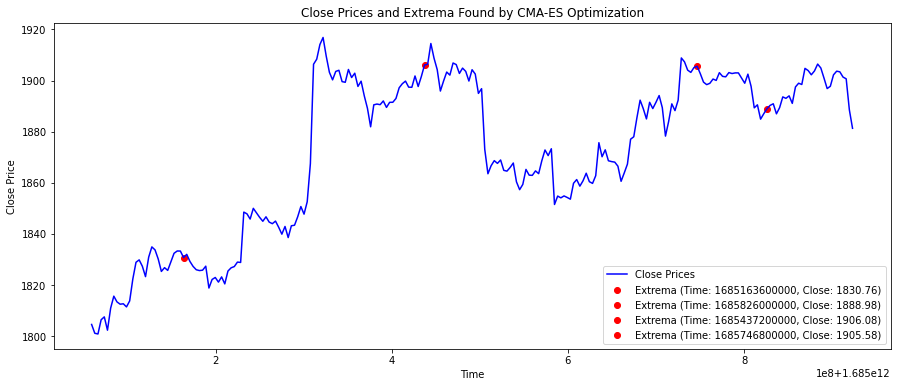

In [269]:
import matplotlib.pyplot as plt

# Plotting the close prices
plt.figure(figsize=(15, 6))
plt.plot(selected_data_3d['open_time'], selected_data_3d['close'], label='Close Prices', color='blue')

# Retrieving the original (non-normalized) points corresponding to the optimized points
optimized_points_original = [selected_data_3d.iloc[xi][['open_time', 'close']].tolist() for xi in result_cma_es_discrete]

# Plotting the extrema found by CMA-ES optimization
for point in optimized_points_original:
    plt.scatter(point[0], point[1], label=f'Extrema (Time: {point[0]}, Close: {point[1]})', color='red')

plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Close Prices and Extrema Found by CMA-ES Optimization')
plt.legend()
plt.show()


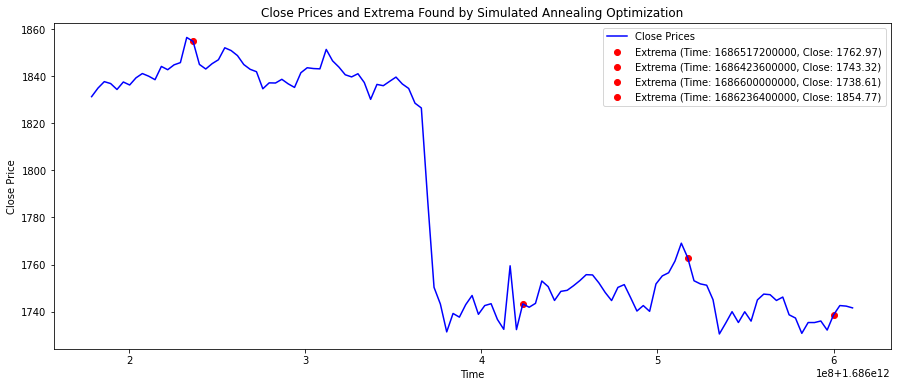

0.5967817306518555


In [272]:
from scipy.optimize import dual_annealing
import time

t = time.time()
random_datum = datetime.utcfromtimestamp(np.random.choice(ohlcv_data['open_time']) / 1000)
time_delta_3d = timedelta(days=5)

# Selecting the data within the 3-day window
selected_data_3d = ohlcv_data[(ohlcv_data['open_time'] >= (random_datum - time_delta_3d).timestamp() * 1000) & (ohlcv_data['open_time'] <= random_datum.timestamp() * 1000)]

selected_data_3d_normalized = selected_data_3d.copy()

# Normalizing the time and close dimensions for the selected data (3-day window)
selected_data_3d_normalized['open_time_normalized'] = (selected_data_3d['open_time'] - selected_data_3d['open_time'].min()) / (selected_data_3d['open_time'].max() - selected_data_3d['open_time'].min())
selected_data_3d_normalized['close_normalized'] = (selected_data_3d['close'] - selected_data_3d['close'].min()) / (selected_data_3d['close'].max() - selected_data_3d['close'].min())

# Converting the normalized data to a list of points (time, close)
normalized_points = selected_data_3d_normalized[['open_time_normalized', 'close_normalized']].values.tolist()

# Defining the objective function to be minimized (negative of the total distance)
def objective_function(x):
    # Retrieving the points corresponding to the given x values
    selected_points = [normalized_points[int(xi)] for xi in x]
    sorted_points = sorted(selected_points, key=lambda p: p[0])

    # Calculating the negative total distance (since we want to maximize the distance)
    return -total_distance(sorted_points)

# Initial guess (selecting 4 random points)
initial_guess = np.random.choice(len(normalized_points), 4, replace=False)

# Bounds to ensure that the x values are within valid range
bounds = [(0, len(normalized_points) - 1)] * 4

# Applying Simulated Annealing optimization method
result_simulated_annealing = dual_annealing(objective_function, bounds, maxiter=100)

# Rounding the result to the nearest possible value (discretizing)
result_simulated_annealing_discrete = [int(round(xi)) for xi in result_simulated_annealing.x]

# Retrieving the corresponding points
optimized_points_simulated_annealing = [normalized_points[xi] for xi in result_simulated_annealing_discrete]

# Plotting the close prices
plt.figure(figsize=(15, 6))
plt.plot(selected_data_3d['open_time'], selected_data_3d['close'], label='Close Prices', color='blue')

# Retrieving the original (non-normalized) points corresponding to the optimized points
optimized_points_original = [selected_data_3d.iloc[xi][['open_time', 'close']].tolist() for xi in result_simulated_annealing_discrete]

# Plotting the extrema found by Simulated Annealing optimization
for point in optimized_points_original:
    plt.scatter(point[0], point[1], label=f'Extrema (Time: {point[0]}, Close: {point[1]})', color='red')

plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Close Prices and Extrema Found by Simulated Annealing Optimization')
plt.legend()
plt.show()

print(time.time()-t)

In [196]:
result_simulated_annealing

     fun: -2.5947690436113646
 message: ['Maximum number of iteration reached']
    nfev: 826
    nhev: 0
     nit: 100
    njev: 5
  status: 0
 success: True
       x: array([238.80018234,  87.49493842, 192.32552759,  12.91609568])

In [1]:
from scipy.optimize import dual_annealing
import time

# Function to calculate distance between two points
def euclidean_distance(point1, point2):
    return  (point1[1] - point2[1]) ** 2 #+ 1*(point1[0] - point2[0]) ** 2

# Function to calculate total distance
def total_distance(points_sequence):
    return -np.max([euclidean_distance(points_sequence[i], points_sequence[i + 1]) for i in range(len(points_sequence) - 1)])+sum([euclidean_distance(points_sequence[i], points_sequence[i + 1]) for i in range(len(points_sequence) - 1)])+np.mean([euclidean_distance(points_sequence[i], points_sequence[i + 1]) for i in range(len(points_sequence) - 1)])

t = time.time()

random_datum = datetime.utcfromtimestamp(np.random.choice(ohlcv_data['open_time']) / 1000)
time_delta_3d = timedelta(days=7)

# Selecting the data within the 3-day window
selected_data_3d = ohlcv_data[(ohlcv_data['open_time'] >= (random_datum - time_delta_3d).timestamp() * 1000) & (ohlcv_data['open_time'] <= random_datum.timestamp() * 1000)]

selected_data_3d_normalized = selected_data_3d.copy()

# Normalizing the time and close dimensions for the selected data (3-day window)
selected_data_3d_normalized['open_time_normalized'] = (selected_data_3d['open_time'] - selected_data_3d['open_time'].min()) / (selected_data_3d['open_time'].max() - selected_data_3d['open_time'].min())
selected_data_3d_normalized['close_normalized'] = (selected_data_3d['close'] - selected_data_3d['close'].min()) / (selected_data_3d['close'].max() - selected_data_3d['close'].min())

# Converting the normalized data to a list of points (time, close)
normalized_points = selected_data_3d_normalized[['open_time_normalized', 'close_normalized']].values.tolist()
# Function to find local extrema (peaks and valleys)
def find_local_extrema(data):
    peaks = []
    valleys = []
    # Handling the first element
    if data[0] > data[1]:
        peaks.append(0)
    if data[0] < data[1]:
        valleys.append(0)
    # Handling elements in between
    for i in range(1, len(data) - 1):
        if data[i] > data[i - 1] and data[i] > data[i + 1]:
            peaks.append(i)
        if data[i] < data[i - 1] and data[i] < data[i + 1]:
            valleys.append(i)
    # Handling the last element
    if data[-1] > data[-2]:
        peaks.append(len(data) - 1)
    if data[-1] < data[-2]:
        valleys.append(len(data) - 1)
    return peaks, valleys

# Finding local extrema for the selected data
peaks, valleys = find_local_extrema(selected_data_3d['close'].values)

# Combining peaks and valleys to form extrema
extrema = peaks + valleys

# Selecting the corresponding normalized points
extrema_points = [normalized_points[ei] for ei in extrema]

# Objective function for Simulated Annealing (working with extrema)
def objective_function_extrema(x):
    selected_points = [extrema_points[int(round(xi))] for xi in x]
    sorted_points = sorted(selected_points, key=lambda p: p[0])
    return -total_distance(sorted_points)

# Bounds for Simulated Annealing (working with extrema)
bounds_extrema = [(0, len(extrema_points) - 1)] * 6

# Measuring execution time for Simulated Annealing (working with extrema)
start_time_simulated_annealing_extrema = time.time()

# Applying Simulated Annealing optimization method (working with extrema)
result_simulated_annealing_extrema = dual_annealing(objective_function_extrema, bounds_extrema, maxiter=500)

# Rounding the result to the nearest possible value (discretizing)
result_simulated_annealing_extrema_discrete = [int(round(xi)) for xi in result_simulated_annealing_extrema.x]

# Retrieving the corresponding points
optimized_points_simulated_annealing_extrema = [extrema_points[xi] for xi in result_simulated_annealing_extrema_discrete]

# Calculating execution time
execution_time_simulated_annealing_extrema = time.time() - start_time_simulated_annealing_extrema

# Plotting the results
plt.figure(figsize=(15, 6))
plt.plot(selected_data_3d['open_time'], selected_data_3d['close'], label='Close Prices', color='blue')
optimized_points_original_sa_extrema = [selected_data_3d.iloc[extrema[xi]][['open_time', 'close']].tolist() for xi in result_simulated_annealing_extrema_discrete]
for point in optimized_points_original_sa_extrema:
    plt.scatter(point[0], point[1], label=f'Extrema (Time: {point[0]}, Close: {point[1]})', color='red')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Close Prices and Extrema Found by Simulated Annealing Optimization (Using Extrema)')
plt.legend()
plt.show()

execution_time_simulated_annealing_extrema


NameError: name 'datetime' is not defined

In [256]:
result_simulated_annealing_extrema.x

array([59.26102782,  8.8332501 , 50.90845536, 42.08096056])

In [50]:
ohlcv_data = pd.read_csv(os.path.join(extract_path, "3months_withAtr14Label.csv"))

In [53]:
# Normalizing the 'open_time' and 'close' columns using min-max normalization
ohlcv_data['open_time_normalized'] = (ohlcv_data['open_time'] - ohlcv_data['open_time'].min()) / (ohlcv_data['open_time'].max() - ohlcv_data['open_time'].min())
ohlcv_data['close_normalized'] = (ohlcv_data['close'] - ohlcv_data['close'].min()) / (ohlcv_data['close'].max() - ohlcv_data['close'].min())

# Displaying the first few rows of the data with the normalized columns
ohlcv_data[['open_time', 'close', 'open_time_normalized', 'close_normalized']].head()



,open_time,close,open_time_normalized,close_normalized
0,1682899200000,1884.08,0.000000,0.641410
1,1682902800000,1834.90,0.000453,0.514491
2,1682906400000,1843.28,0.000906,0.536117
3,1682910000000,1845.94,0.001359,0.542982
4,1682913600000,1846.80,0.001812,0.545201


In [2]:
from scipy.signal import detrend


def total_distance(points_sequence):
    return sum(distance(points_sequence[i], points_sequence[i + 1]) for i in range(len(points_sequence) - 1))

def detrend_time_series(ohlcv_data: pd.DataFrame):
    # Calculating the difference between consecutive 'close' values to remove the trend
    ohlcv_data['close_detrended'] = ohlcv_data['close'].diff()
    
    # Normalizing the detrended 'close' values
    ohlcv_data['close_detrended_normalized'] = (ohlcv_data['close_detrended'] - ohlcv_data['close_detrended'].min()) / (ohlcv_data['close_detrended'].max() - ohlcv_data['close_detrended'].min())
    
    return ohlcv_data

def detrend_time_series_scipy(ohlcv_data: pd.DataFrame):
    # Apply the detrend function to the 'close' column
    ohlcv_data['close_detrended_scipy'] = detrend(ohlcv_data['close'])
    
    # Normalizing the detrended 'close' values
    ohlcv_data['close_detrended_scipy_normalized'] = (ohlcv_data['close_detrended_scipy'] - ohlcv_data['close_detrended_scipy'].min()) / (ohlcv_data['close_detrended_scipy'].max() - ohlcv_data['close_detrended_scipy'].min())
    
    return ohlcv_data

def rolling_min_max_normalization(ohlcv_data: pd.DataFrame, time_delta: timedelta, frequency='1H'):
    frequency_seconds = pd.Timedelta(frequency).total_seconds()

    # Convert the timedelta to the number of periods based on the given frequency
    window_size = int(time_delta.total_seconds() // frequency_seconds)

    # Apply rolling window and calculate min and max for each window
    rolling_min = ohlcv_data['close'].rolling(window=window_size, min_periods=1).min()
    rolling_max = ohlcv_data['close'].rolling(window=window_size, min_periods=1).max()

    # Apply min-max normalization within the rolling window
    ohlcv_data['close_rolling_normalized'] = (ohlcv_data['close'] - rolling_min) / (rolling_max - rolling_min)

    return ohlcv_data

# Test the function with a time delta of 6 hours
rolling_time_delta = timedelta(hours=6)
normalized_data = rolling_min_max_normalization(ohlcv_data.copy(), rolling_time_delta)

# Displaying the first few rows of the normalized data
normalized_data[['open_time', 'close', 'close_rolling_normalized']].head(10)

# Applying the detrending function to the data
detrended_data = detrend_time_series(ohlcv_data.copy())

# Displaying the first few rows of the detrended data
detrended_data[['open_time', 'close', 'close_detrended', 'close_detrended_normalized']].head()


NameError: name 'pd' is not defined

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from itertools import combinations
from scipy.signal import detrend

# Function to calculate distance between two points
def euclidean_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

# Function to calculate total distance
def total_distance(points_sequence):
    return sum(euclidean_distance(points_sequence[i], points_sequence[i + 1]) for i in range(len(points_sequence) - 1))

def scalar_distance(value1, value2):
    return value1 - value2

# Function to find optimized points
def find_optimized_points(datum: datetime, time_delta: timedelta, ohlcv_data: pd.DataFrame):
    end_time = datum.timestamp() * 1000
    start_time = (datum - time_delta).timestamp() * 1000
    selected_data = ohlcv_data[(ohlcv_data['open_time'] >= start_time) & (ohlcv_data['open_time'] <= end_time)]
    selected_points = selected_data[['open_time_normalized', 'close_normalized']].values
    all_combinations = combinations(selected_points, 4)
    max_total_distance = 0
    best_combination = None
    for combination in all_combinations:
        sorted_combination = sorted(combination, key=lambda x: x[0])
        distance_combination = total_distance(sorted_combination)
        if distance_combination > max_total_distance:
            max_total_distance = distance_combination
            best_combination = sorted_combination

    # Check if best_combination is None
    if best_combination is None:
        return None
    
    best_combination_set = set(tuple(point) for point in best_combination)
    best_combination_df = selected_data[selected_data.apply(lambda row: (row['open_time_normalized'], row['close_normalized']) in best_combination_set, axis=1)]
    return best_combination_df[['open_time', 'close', 'open_time_normalized', 'close_normalized']]

# Function to find optimized points with detrended data
def find_optimized_points_detrend(datum: datetime, time_delta: timedelta, ohlcv_data: pd.DataFrame):
    end_time = datum.timestamp() * 1000
    start_time = (datum - time_delta).timestamp() * 1000
    selected_data = ohlcv_data[(ohlcv_data['open_time'] >= start_time) & (ohlcv_data['open_time'] <= end_time)]
    selected_data['close_detrended'] = detrend(selected_data['close'].values)
    selected_data['close_detrended_normalized'] = (selected_data['close_detrended'] - selected_data['close_detrended'].min()) / (selected_data['close_detrended'].max() - selected_data['close_detrended'].min())
    selected_points = selected_data[['open_time_normalized', 'close_detrended_normalized']].values
    all_combinations = combinations(selected_points, 4)
    max_total_distance = 0
    best_combination = None
    for combination in all_combinations:
        sorted_combination = sorted(combination, key=lambda x: x[0])
        distance_combination = total_distance(sorted_combination)
        if distance_combination > max_total_distance:
            max_total_distance = distance_combination
            best_combination = sorted_combination
    best_combination_set = set(tuple(point) for point in best_combination)
    best_combination_df = selected_data[selected_data.apply(lambda row: (row['open_time_normalized'], row['close_detrended_normalized']) in best_combination_set, axis=1)]
    return best_combination_df[['open_time', 'close_detrended', 'open_time_normalized', 'close_detrended_normalized']]

# Function to calculate log returns
def log_returns(prices):
    return np.diff(np.log(prices))

# Final function to extract specified features with 'quote_volume'
def extract_final_features_corrected(ohlcv_data, time_delta):
    # Columns to store the extracted features
    columns = [
        'normalized_close', 'mean_log_return_p0_p1', 'var_log_return_p0_p1', 'cor_vol_price_p0_p1',
        'mean_log_return_p1_p2', 'var_log_return_p1_p2', 'cor_vol_price_p1_p2',
        'mean_log_return_p2_p3', 'var_log_return_p2_p3', 'cor_vol_price_p2_p3'
    ]
    for i in range(4):
        columns.append(f'dist_to_landmark_{i}')
    features_data = {col: [] for col in columns}

    # Iterate through the DataFrame
    for i, row in ohlcv_data.iterrows():
        # Current timestamp and close price
        current_time = row['open_time']
        current_date = datetime.fromtimestamp(current_time / 1000)

        # Find optimized points for trend data
        trend_optimized_points = find_optimized_points(current_date, time_delta, ohlcv_data)

        # Normalized close price
        normalized_close = (row['close'] - trend_optimized_points['close'].min()) / (trend_optimized_points['close'].max() - trend_optimized_points['close'].min()) if trend_optimized_points is not None else np.nan
        features_data['normalized_close'].append(normalized_close)

        # Distance to normalized landmarks
        dist_to_landmarks = [scalar_distance(normalized_close, point) for point in trend_optimized_points['close_normalized'].values] if trend_optimized_points is not None else [np.nan] * 4
        for j, dist in enumerate(dist_to_landmarks):
            features_data[f'dist_to_landmark_{j}'].append(dist)

        # Mean, Variance of log returns, and Correlation between volume and price increase between optimized points
        if trend_optimized_points is not None:
            optimized_time_indices = trend_optimized_points.index.values
            for k in range(3):
                start_idx, end_idx = optimized_time_indices[k], optimized_time_indices[k + 1]
                subset_data = ohlcv_data.loc[start_idx:end_idx]

                # Log returns of close prices
                log_ret = log_returns(subset_data['close'].values)
                mean_log_return = np.mean(log_ret)
                var_log_return = np.var(log_ret)

                # Correlation between quote volume increase and price increase
                volume_diff = np.diff(subset_data['quote_volume'].values)  # Updated column name
                price_diff = np.diff(subset_data['close'].values)
                cor_vol_price = np.corrcoef(volume_diff, price_diff)[0, 1] if len(volume_diff) > 1 else np.nan

                features_data[f'mean_log_return_p{k}_p{k+1}'].append(mean_log_return)
                features_data[f'var_log_return_p{k}_p{k+1}'].append(var_log_return)
                features_data[f'cor_vol_price_p{k}_p{k+1}'].append(cor_vol_price)
        else:
            for k in range(3):
                features_data[f'mean_log_return_p{k}_p{k+1}'].append(np.nan)
                features_data[f'var_log_return_p{k}_p{k+1}'].append(np.nan)
                features_data[f'cor_vol_price_p{k}_p{k+1}'].append(np.nan)

    # Add the extracted features to the DataFrame
    for col, values in features_data.items():
        ohlcv_data[col] = values

    return ohlcv_data
ohlcv_data = pd.read_csv("eth1h.csv")
# Test the corrected function on the first 100 rows
subset_data = ohlcv_data.copy()
time_delta = timedelta(hours=24)
final_features_data_corrected = extract_final_features_corrected(subset_data, time_delta)


KeyError: 'open_time'

In [5]:
ohlcv_data

,Unnamed: 0,Open_time,Open,High,Low,Close,Volume,Close_time,Quote_asset_volume,Number_of_trades,Taker_buy_base_asset_volume,Taker_buy_quote_asset_volume,Ignore
0,0,2021-12-01 00:00:00,4630.25,4731.40,4598.77,4723.92,41743.3235,1638320399999,1.954175e+08,109065,21994.4734,1.029365e+08,0
1,1,2021-12-01 01:00:00,4723.91,4723.92,4680.24,4690.57,18184.0592,1638323999999,8.546848e+07,41558,7796.0159,3.664304e+07,0
2,2,2021-12-01 02:00:00,4690.56,4750.00,4665.20,4748.91,22668.9820,1638327599999,1.067585e+08,65428,10313.0445,4.856948e+07,0
3,3,2021-12-01 03:00:00,4748.92,4769.07,4716.54,4759.37,27490.5019,1638331199999,1.304372e+08,88517,14610.3057,6.932975e+07,0
4,4,2021-12-01 04:00:00,4759.37,4762.73,4712.22,4726.85,18072.6271,1638334799999,8.559542e+07,43581,8429.8275,3.992798e+07,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13866,13870,2023-08-11 18:59:42.720,1843.95,1844.61,1841.64,1843.97,24912.9830,1691783999999,4.592308e+07,23582,12251.8040,2.258397e+07,0
13867,13871,2023-08-11 20:00:52.736,1843.98,1845.10,1843.22,1845.09,18963.4050,1691787599999,3.497073e+07,18530,11072.4500,2.041911e+07,0
13868,13872,2023-08-11 20:59:51.680,1845.10,1845.84,1843.00,1844.83,14427.8070,1691791199999,2.661282e+07,18769,5917.5300,1.091585e+07,0
13869,13873,2023-08-11 22:01:01.696,1844.82,1846.67,1844.27,1845.72,12951.2090,1691794799999,2.390141e+07,14867,6731.6770,1.242337e+07,0


In [62]:
final_features_data_corrected

,Unnamed: 0.1,Unnamed: 0,open_time,open,high,low,close,volume,close_time,quote_volume,...,mean_log_return_p1_p2,var_log_return_p1_p2,cor_vol_price_p1_p2,mean_log_return_p2_p3,var_log_return_p2_p3,cor_vol_price_p2_p3,dist_to_landmark_0,dist_to_landmark_1,dist_to_landmark_2,dist_to_landmark_3
0,0,0,1682899200000,1868.41,1885.56,1867.20,1884.08,172201.437,1682902799999,3.233506e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1682902800000,1884.09,1884.90,1821.17,1834.90,515365.298,1682906399999,9.502794e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,1682906400000,1834.89,1846.19,1832.21,1843.28,204270.793,1682909999999,3.762016e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,1682910000000,1843.28,1846.74,1841.20,1845.94,98998.300,1682913599999,1.825534e+08,...,0.004557,0.000000,NaN,0.001442,0.000000,NaN,-0.416929,-0.290009,-0.311636,-0.318500
4,4,4,1682913600000,1845.94,1846.95,1841.44,1846.80,73249.415,1682917199999,1.350939e+08,...,0.004557,0.000000,NaN,0.001442,0.000000,NaN,-0.399442,-0.272522,-0.294149,-0.301013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,251,1686481200000,1750.31,1754.47,1749.07,1751.49,43561.854,1686484799999,7.630535e+07,...,0.001288,0.000002,-0.070408,-0.007577,0.000066,-0.585976,0.148088,0.202799,0.178411,0.457644
996,996,252,1686484800000,1751.48,1751.77,1745.65,1745.97,44343.143,1686488399999,7.754272e+07,...,0.001288,0.000002,-0.070408,-0.007577,0.000066,-0.585976,-0.055677,-0.000966,-0.025354,0.253879
997,997,253,1686488400000,1745.96,1748.81,1737.29,1740.27,107223.900,1686491999999,1.869387e+08,...,0.001288,0.000002,-0.070408,-0.007577,0.000066,-0.585976,-0.266087,-0.211376,-0.235764,0.043469
998,998,254,1686492000000,1740.27,1750.53,1739.37,1742.59,94931.574,1686495599999,1.655623e+08,...,0.001288,0.000002,-0.070408,-0.007577,0.000066,-0.585976,-0.180447,-0.125735,-0.150123,0.129110


In [57]:
final_features_data_corrected[feature_columns].describe()

,normalized_close,mean_log_return_p0_p1,var_log_return_p0_p1,cor_vol_price_p0_p1,mean_log_return_p1_p2,var_log_return_p1_p2,cor_vol_price_p1_p2,mean_log_return_p2_p3,var_log_return_p2_p3,cor_vol_price_p2_p3,dist_to_landmark_0,dist_to_landmark_1,dist_to_landmark_2,dist_to_landmark_3
count,2205.000000,2205.000000,2.205000e+03,1916.000000,2205.000000,2205.000000,2053.000000,2205.000000,2.205000e+03,1972.000000,2205.000000,2205.000000,2205.000000,2205.000000
mean,0.493806,-0.000355,1.178551e-05,-0.006397,-0.000232,0.000011,-0.089340,-0.000027,7.622584e-06,-0.052488,-0.063678,-0.063581,-0.062375,-0.062828
std,0.338222,0.004944,3.554836e-05,0.726188,0.004038,0.000022,0.665860,0.003670,1.518104e-05,0.656015,0.420044,0.397442,0.395078,0.355687
min,-0.235019,-0.053728,0.000000e+00,-1.000000,-0.016541,0.000000,-1.000000,-0.027739,0.000000e+00,-1.000000,-0.928850,-0.934645,-1.000000,-0.874563
25%,0.180484,-0.002137,9.009366e-07,-0.738661,-0.001946,0.000002,-0.716799,-0.001821,9.708356e-07,-0.651491,-0.430792,-0.394112,-0.393699,-0.360063
50%,0.476096,0.000382,4.015451e-06,-0.046128,-0.000110,0.000004,-0.168216,0.000412,3.101615e-06,-0.117698,-0.071810,-0.081341,-0.064683,-0.069009
75%,0.810324,0.001884,1.054796e-05,0.712430,0.001608,0.000010,0.500666,0.001551,7.030093e-06,0.549397,0.288972,0.256894,0.237535,0.205119
max,1.304406,0.020239,6.382279e-04,1.000000,0.020239,0.000253,1.000000,0.020239,2.531467e-04,1.000000,1.000000,0.951018,1.000000,0.912488


In [58]:
final_features_data_corrected.to_csv(os.path.join(extract_path, "3months_withAtr14Label_wtihFeatures.csv"))

In [34]:
# Define the feature columns that need to be normalized
feature_columns = [
    'normalized_close', 'mean_log_return_p0_p1', 'var_log_return_p0_p1', 'cor_vol_price_p0_p1',
    'mean_log_return_p1_p2', 'var_log_return_p1_p2', 'cor_vol_price_p1_p2',
    'mean_log_return_p2_p3', 'var_log_return_p2_p3', 'cor_vol_price_p2_p3'
] + [f'dist_to_landmark_{i}' for i in range(4)]

# Normalize the specified feature columns to the range [-1, 1]
for col in feature_columns:
    min_val = final_features_data_corrected[col].min()
    max_val = final_features_data_corrected[col].max()
    final_features_data_corrected[col] = 2 * (final_features_data_corrected[col] - min_val) / (max_val - min_val) - 1

# Display the normalized features for the first few rows
final_features_data_corrected[feature_columns].head(30)

,normalized_close,mean_log_return_p0_p1,var_log_return_p0_p1,cor_vol_price_p0_p1,mean_log_return_p1_p2,var_log_return_p1_p2,cor_vol_price_p1_p2,mean_log_return_p2_p3,var_log_return_p2_p3,cor_vol_price_p2_p3,dist_to_landmark_0,dist_to_landmark_1,dist_to_landmark_2,dist_to_landmark_3
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.799263,-0.158840,-1.000000,NaN,-0.544804,-1.000000,NaN,-0.072199,-1.000000,NaN,-0.632089,-0.491764,-0.434314,-0.685473
4,-0.799263,-0.206846,-0.991748,1.000000,-0.048058,-1.000000,NaN,-0.363083,-1.000000,NaN,-0.632089,-0.448119,-0.429510,-0.654762
5,-0.484595,-0.206846,-0.991748,1.000000,-0.185028,-0.975812,-1.000000,0.256244,-1.000000,NaN,-0.430555,-0.261306,-0.216664,-0.457871
6,-0.311482,-0.206846,-0.991748,1.000000,-0.185028,-0.975812,-1.000000,0.196986,-0.994962,-1.000000,-0.319683,-0.158533,-0.113938,-0.349552
7,-0.365580,-0.139597,-0.971036,0.132431,0.205448,-0.995985,-1.000000,-0.051890,-1.000000,NaN,-0.354331,-0.159711,-0.175915,-0.383402
8,-0.799263,-0.139597,-0.971036,0.132431,0.205448,-0.995985,-1.000000,-0.220302,-0.959305,-1.000000,-0.632089,-0.417181,-0.433265,-0.653074
9,-0.673873,-0.139597,-0.971036,0.132431,0.205448,-0.995985,-1.000000,-0.220302,-0.959305,-1.000000,-0.551781,-0.342739,-0.358858,-0.565586


In [35]:
final_features_data_corrected[feature_columns].describe()

,normalized_close,mean_log_return_p0_p1,var_log_return_p0_p1,cor_vol_price_p0_p1,mean_log_return_p1_p2,var_log_return_p1_p2,cor_vol_price_p1_p2,mean_log_return_p2_p3,var_log_return_p2_p3,cor_vol_price_p2_p3,dist_to_landmark_0,dist_to_landmark_1,dist_to_landmark_2,dist_to_landmark_3
count,741.000000,741.000000,741.000000,664.000000,741.000000,741.000000,699.000000,741.000000,741.000000,649.000000,741.000000,741.000000,741.000000,741.000000
mean,-0.047389,0.021416,-0.871044,0.011717,0.001334,-0.835042,-0.016554,-0.012483,-0.876242,-0.061965,0.069626,0.125631,0.150103,0.002446
std,0.538528,0.211430,0.244084,0.684713,0.375105,0.259191,0.685852,0.339404,0.214218,0.603140,0.468650,0.397040,0.392658,0.395201
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.510071,-0.092841,-0.982453,-0.630636,-0.235808,-0.965287,-0.665354,-0.197735,-0.973201,-0.529517,-0.279533,-0.178184,-0.125352,-0.289986
50%,-0.134074,0.006993,-0.940308,-0.075539,0.030379,-0.911471,-0.127332,-0.042080,-0.941973,-0.160610,0.037585,0.108816,0.119089,-0.018476
75%,0.424696,0.130860,-0.895667,0.685250,0.215560,-0.836160,0.641748,0.183307,-0.865851,0.399169,0.476787,0.444472,0.456234,0.288521
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
